In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('pretrained_model/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('pretrained_model/trfm_pretrained.pkl'))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('pretrained_model/rnn_pretrained.pkl'))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# BACE dataset

In [5]:
df = pd.read_csv('dataset/bace.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(1513, 595)


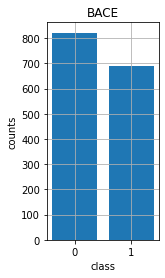

In [6]:
keys = ['0', '1']
bottom = df.groupby('Class').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

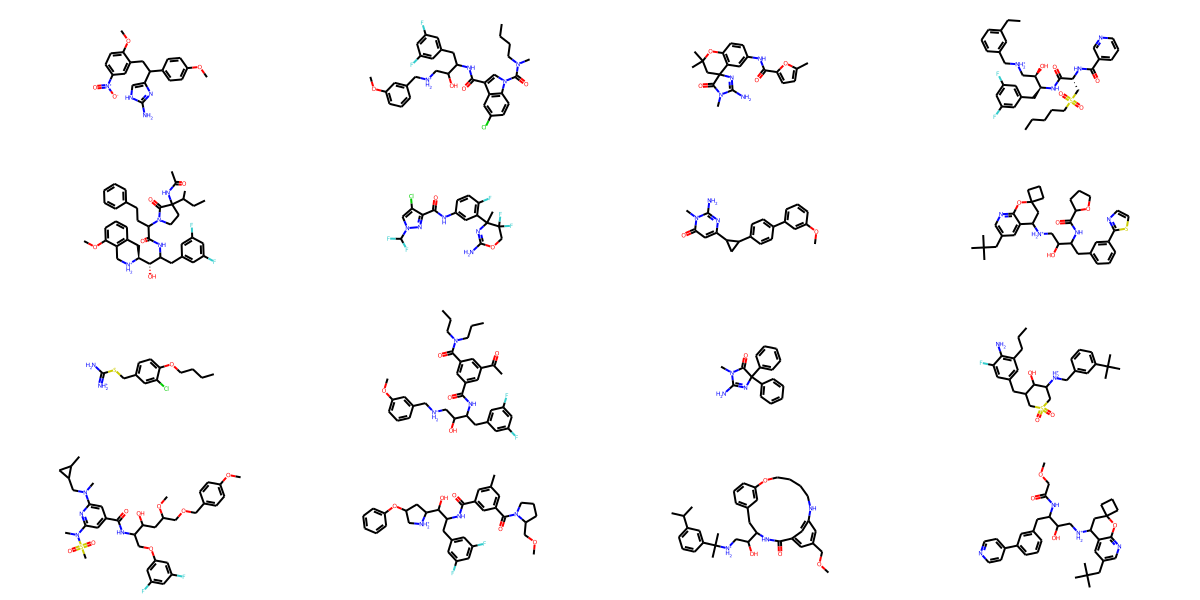

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.6034960133141962, 'roc_auc std': 0.044765055582521036, 'prc_auc mean': 0.551655262736957, 'prc_auc std': 0.03733360366393018}
0.025 {'roc_auc mean': 0.6201865051762285, 'roc_auc std': 0.034127942188955936, 'prc_auc mean': 0.5592014723213092, 'prc_auc std': 0.03387374978598396}
0.05 {'roc_auc mean': 0.6135010631103627, 'roc_auc std': 0.028158138794109812, 'prc_auc mean': 0.5604831673279472, 'prc_auc std': 0.02426104861731677}
0.1 {'roc_auc mean': 0.6245545102980795, 'roc_auc std': 0.024978755195524845, 'prc_auc mean': 0.5757954881087686, 'prc_auc std': 0.028798962706770362}
0.2 {'roc_auc mean': 0.657442273973958, 'roc_auc std': 0.01594241443238669, 'prc_auc mean': 0.6046140502959714, 'prc_auc std': 0.015143133071302417}
0.4 {'roc_auc mean': 0.7006352794545322, 'roc_auc std': 0.013020847196393837, 'prc_auc mean': 0.6421262860414687, 'prc_auc std': 0.013439232189133034}
0.8 {'roc_auc mean': 0.7377646025472112, 'roc_auc std': 0.024879600716773212, 'prc_auc mean': 

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6076738743157181, 'roc_auc std': 0.04102799245507257, 'prc_auc mean': 0.5589281069435723, 'prc_auc std': 0.04208049296853323}
0.025 {'roc_auc mean': 0.6301808997535835, 'roc_auc std': 0.03403628306824021, 'prc_auc mean': 0.5830377672027438, 'prc_auc std': 0.03309625529962197}
0.05 {'roc_auc mean': 0.6677602281740812, 'roc_auc std': 0.029267871315462553, 'prc_auc mean': 0.6108106502517667, 'prc_auc std': 0.03083714232889703}
0.1 {'roc_auc mean': 0.6916510059094464, 'roc_auc std': 0.025361139269467994, 'prc_auc mean': 0.6390799793104676, 'prc_auc std': 0.030787020245921632}
0.2 {'roc_auc mean': 0.7470976217042161, 'roc_auc std': 0.014522813760564865, 'prc_auc mean': 0.7061323405004474, 'prc_auc std': 0.016553756726961577}
0.4 {'roc_auc mean': 0.7788897578142183, 'roc_auc std': 0.012316923442962603, 'prc_auc mean': 0.7370471811432577, 'prc_auc std': 0.02005248242920688}
0.8 {'roc_auc mean': 0.8120805884936318, 'roc_auc std': 0.02302299472951871, 'prc_auc mean': 0

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5904351545990234, 'roc_auc std': 0.056746589072704065, 'prc_auc mean': 0.5535515620597102, 'prc_auc std': 0.048251721291181236}
0.025 {'roc_auc mean': 0.6106461405832599, 'roc_auc std': 0.05047426648353956, 'prc_auc mean': 0.554645176728919, 'prc_auc std': 0.04257053865547211}
0.05 {'roc_auc mean': 0.6444147241272458, 'roc_auc std': 0.023054155272907773, 'prc_auc mean': 0.5857514982644058, 'prc_auc std': 0.02444405291639778}
0.1 {'roc_auc mean': 0.6741187429390806, 'roc_auc std': 0.020468004520679147, 'prc_auc mean': 0.6192394868892339, 'prc_auc std': 0.017253426958478132}
0.2 {'roc_auc mean': 0.700307386622842, 'roc_auc std': 0.017323734327161226, 'prc_auc mean': 0.6459261914650007, 'prc_auc std': 0.020598323623236412}
0.4 {'roc_auc mean': 0.7376849385371098, 'roc_auc std': 0.01696724127134409, 'prc_auc mean': 0.6775004197116022, 'prc_auc std': 0.01836161391741565}
0.8 {'roc_auc mean': 0.7655753184014055, 'roc_auc std': 0.018940553069619403, 'prc_auc mean': 0

Classification evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_24308\149481803.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


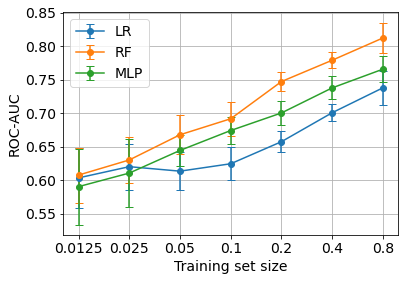

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5989689792209104, 'roc_auc std': 0.05740637757553807, 'prc_auc mean': 0.5456897017764587, 'prc_auc std': 0.05867596955460592}
0.025 {'roc_auc mean': 0.6378519576429846, 'roc_auc std': 0.04335955192589746, 'prc_auc mean': 0.5813720359431355, 'prc_auc std': 0.04427906869056823}
0.05 {'roc_auc mean': 0.6773272957239771, 'roc_auc std': 0.028858302176482196, 'prc_auc mean': 0.6187007870970807, 'prc_auc std': 0.036570558460861574}
0.1 {'roc_auc mean': 0.7212617319892239, 'roc_auc std': 0.0231916115915048, 'prc_auc mean': 0.6607849003205102, 'prc_auc std': 0.02878290706876791}
0.2 {'roc_auc mean': 0.7773119266559305, 'roc_auc std': 0.012811411772714934, 'prc_auc mean': 0.7168255368264145, 'prc_auc std': 0.01908591976599435}
0.4 {'roc_auc mean': 0.8045221046457636, 'roc_auc std': 0.012434357641774208, 'prc_auc mean': 0.7491596782871391, 'prc_auc std': 0.019012237626459823}
0.8 {'roc_auc mean': 0.8366315327184892, 'roc_auc std': 0.022738126016606346, 'prc_auc mean': 0.

ST + Random Forest Classifier

In [14]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.5708606805674761, 'roc_auc std': 0.037336720746558985, 'prc_auc mean': 0.5343685992367233, 'prc_auc std': 0.03804440097182642}
0.025 {'roc_auc mean': 0.5952902424946536, 'roc_auc std': 0.0318954232692298, 'prc_auc mean': 0.5554920477771573, 'prc_auc std': 0.03174413617502197}
0.05 {'roc_auc mean': 0.633246169976828, 'roc_auc std': 0.023457702110031346, 'prc_auc mean': 0.5850978237284745, 'prc_auc std': 0.023882382809138812}
0.1 {'roc_auc mean': 0.676444501173199, 'roc_auc std': 0.02088278020711582, 'prc_auc mean': 0.6342855926078791, 'prc_auc std': 0.02288194115787629}
0.2 {'roc_auc mean': 0.7245309502739959, 'roc_auc std': 0.016022215609998395, 'prc_auc mean': 0.6843302996753573, 'prc_auc std': 0.017768866526384104}
0.4 {'roc_auc mean': 0.7668250690388327, 'roc_auc std': 0.014333861262377555, 'prc_auc mean': 0.7261237364468742, 'prc_auc std': 0.019563630770092346}
0.8 {'roc_auc mean': 0.8019609134826526, 'roc_auc std': 0.023419290026075425, 'prc_auc mean': 0.

ST + Multi-layer Perceptron Classifier (MLP)

In [15]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5897048031359764, 'roc_auc std': 0.05002590769013533, 'prc_auc mean': 0.5426178805437731, 'prc_auc std': 0.05740945038217776}
0.025 {'roc_auc mean': 0.6152509582867756, 'roc_auc std': 0.03291716075263502, 'prc_auc mean': 0.5609289763165353, 'prc_auc std': 0.0367315280134728}
0.05 {'roc_auc mean': 0.6895547214378007, 'roc_auc std': 0.03287020751903318, 'prc_auc mean': 0.628263169780016, 'prc_auc std': 0.03667478772137234}
0.1 {'roc_auc mean': 0.733847169114452, 'roc_auc std': 0.017368248672079315, 'prc_auc mean': 0.6815350050291558, 'prc_auc std': 0.02116841398197732}
0.2 {'roc_auc mean': 0.7751769156356321, 'roc_auc std': 0.012189181779774965, 'prc_auc mean': 0.7234243306830226, 'prc_auc std': 0.014881937876502108}
0.4 {'roc_auc mean': 0.7897086927833036, 'roc_auc std': 0.012851044402249299, 'prc_auc mean': 0.7410697175354233, 'prc_auc std': 0.021413654063736694}
0.8 {'roc_auc mean': 0.8510057092665788, 'roc_auc std': 0.017026497945094865, 'prc_auc mean': 0.80

SMILES TRANSFORMER evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_24308\351139279.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


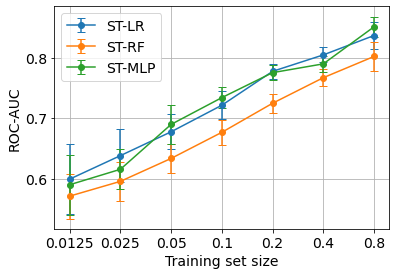

In [16]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BACE_st_eval.png', dpi=300)
fig.show()

# Pre-training RNN model

In [17]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


RNN + Logistic Regression

In [18]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5549738007486532, 'roc_auc std': 0.04328352206261068, 'prc_auc mean': 0.502533154024777, 'prc_auc std': 0.03555593479827547}
0.025 {'roc_auc mean': 0.579507740293184, 'roc_auc std': 0.050991661870654195, 'prc_auc mean': 0.5234660620612276, 'prc_auc std': 0.04276941806363568}
0.05 {'roc_auc mean': 0.6156414618888089, 'roc_auc std': 0.02880800607079733, 'prc_auc mean': 0.5538389341538675, 'prc_auc std': 0.024840904617333716}
0.1 {'roc_auc mean': 0.6699579603719474, 'roc_auc std': 0.026686850051143674, 'prc_auc mean': 0.5979226418955879, 'prc_auc std': 0.027945095795536144}
0.2 {'roc_auc mean': 0.7217014680906028, 'roc_auc std': 0.015404594848623474, 'prc_auc mean': 0.655742392443005, 'prc_auc std': 0.024328492512128354}
0.4 {'roc_auc mean': 0.7510486571030572, 'roc_auc std': 0.013325540986588412, 'prc_auc mean': 0.6869903710756512, 'prc_auc std': 0.019126944491093877}
0.8 {'roc_auc mean': 0.7869433465085638, 'roc_auc std': 0.024425261504800233, 'prc_auc mean': 0

RNN + Random Forest Classifier

In [19]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

0.0125 {'roc_auc mean': 0.5720782786028027, 'roc_auc std': 0.05651912148954248, 'prc_auc mean': 0.5377113825984018, 'prc_auc std': 0.042679192326210307}
0.025 {'roc_auc mean': 0.636285630508299, 'roc_auc std': 0.03970170670575691, 'prc_auc mean': 0.5870748813183303, 'prc_auc std': 0.04565910855525452}
0.05 {'roc_auc mean': 0.6735955932077868, 'roc_auc std': 0.04446160617791893, 'prc_auc mean': 0.6317634711758131, 'prc_auc std': 0.04843767746481951}
0.1 {'roc_auc mean': 0.7308697966455202, 'roc_auc std': 0.019665131065644766, 'prc_auc mean': 0.6961327052130893, 'prc_auc std': 0.02487512096000997}
0.2 {'roc_auc mean': 0.7784298273578216, 'roc_auc std': 0.012482679411271035, 'prc_auc mean': 0.7464298617474074, 'prc_auc std': 0.015400168249635528}
0.4 {'roc_auc mean': 0.818047606246487, 'roc_auc std': 0.01239905432355415, 'prc_auc mean': 0.7881003029901358, 'prc_auc std': 0.01725982398863701}
0.8 {'roc_auc mean': 0.8381291172595521, 'roc_auc std': 0.017517186804073628, 'prc_auc mean': 0.80

RNN + Multi-layer Perceptron Classifier (MLP)

In [20]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5833550458351665, 'roc_auc std': 0.038729482199171626, 'prc_auc mean': 0.5307911436067206, 'prc_auc std': 0.040381855923426496}
0.025 {'roc_auc mean': 0.6003850721860038, 'roc_auc std': 0.03693283591276337, 'prc_auc mean': 0.543455174316396, 'prc_auc std': 0.03301714403390159}
0.05 {'roc_auc mean': 0.6226885388712515, 'roc_auc std': 0.03481661218577866, 'prc_auc mean': 0.5526984093214803, 'prc_auc std': 0.03701817371090787}
0.1 {'roc_auc mean': 0.672896877987312, 'roc_auc std': 0.032834285989727374, 'prc_auc mean': 0.6047001491327315, 'prc_auc std': 0.03730572405602008}
0.2 {'roc_auc mean': 0.7024159461791719, 'roc_auc std': 0.01417502055974898, 'prc_auc mean': 0.6388053350870121, 'prc_auc std': 0.019931573415708663}
0.4 {'roc_auc mean': 0.6588642195557078, 'roc_auc std': 0.025719348574335704, 'prc_auc mean': 0.5948638485616949, 'prc_auc std': 0.02523018376716309}
0.8 {'roc_auc mean': 0.7077953447518665, 'roc_auc std': 0.027490218468975095, 'prc_auc mean': 0.6

# Pre-training RNN Evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_24308\1491995531.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


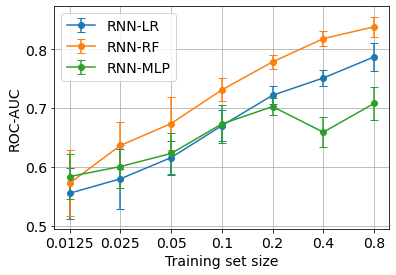

In [21]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Classification evaluation with Pre-training Smiles Transformer, RNN and without pre-training

C:\Users\anhtt\AppData\Local\Temp\ipykernel_24308\3595140661.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


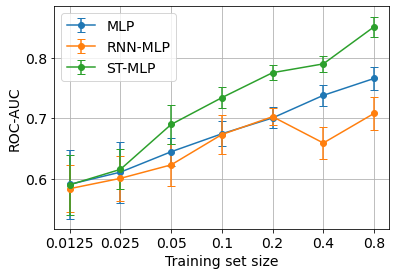

In [22]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BACE_pretrain_eval.png', dpi=300)
fig.show()

# Visualization of the Latent Space

In [23]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X_sf)

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

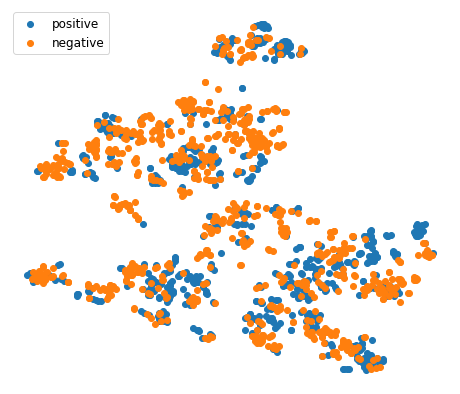

In [25]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['Class']==1][:,0], X_reduced[df['Class']==1][:,1], label='positive', marker='o')
plt.scatter(X_reduced[df['Class']==0][:,0], X_reduced[df['Class']==0][:,1], label='negative', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('figures/BACE.png', dpi=300)
plt.show()